In [1]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import csv
import pandas as pd
import keras
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

In [2]:
# N_Steps_In je input rolling window, N_Steps_Out je output rolling window (tj forecast period, ali continuos)
n_steps_in = 30
n_steps_out = 5

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', header=0, index_col=None)

# Convert Date column to date, but in this case Date is index column
dataset['Date'] = pd.to_datetime(dataset['Date'], origin='1900-01-01', unit='D')

timestamps = dataset['Date'].copy()
dataset = dataset.drop('Date', axis=1)

dataset = dataset.astype('float32')

# integer encode direction
encoder = LabelEncoder()
dataset['CT'] = encoder.fit_transform(dataset['CT'])

# Shifted target kolona
dataset['Adj Close_Shifted'] = dataset['Adj Close'].shift(periods=-n_steps_out)

dataset = dataset.dropna()

training_data = dataset.iloc[:-503+n_steps_out].copy()
validation_data = dataset.iloc[-503+n_steps_out:-251+n_steps_out:].copy()
testing_data = dataset.iloc[-251+n_steps_out:].copy()

#Exported values
training_values = training_data.values
validation_values = validation_data.values
testing_values = testing_data.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

training_scaled = scaler.fit_transform(training_values)
validation_scaled = scaler.fit_transform(validation_values)
testing_scaled = scaler.fit_transform(testing_values)

x_training, y_training = split_sequences(training_scaled, n_steps_in, n_steps_out)
x_validation, y_validation = split_sequences(validation_scaled, n_steps_in, n_steps_out)
x_testing, y_testing = split_sequences(testing_scaled, n_steps_in, n_steps_out)

n_features = x_training.shape[2] #Broj kolona

# print('This is X[0]')
# print(X[0])
# print('This is y[0]') #Y je set odgovora, svaki row je zapravo serija odgovora.
# print(y[0])
# print(n_features)


In [3]:
#My model code

# Model Code 1
# Create the model
inputs = keras.layers.Input(shape=(x_training.shape[1], x_training.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(n_steps_out, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

# # Model Code 2
# # define model
# model = Sequential()
# model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(LSTM(100, activation='relu'))
# model.add(Dense(n_steps_out))
# model.compile(optimizer='adam', loss='mse')
# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 63)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 150)             │         128,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 150)             │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 490,355 (1.87 MB)

 Trainable params: 490,355 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0036 - val_loss: 0.0727
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0072 - val_loss: 0.0844
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0039 - val_loss: 0.0390
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0044 - val_loss: 0.0945
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0043 - val_loss: 0.0618
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0022 - val_loss: 0.0680
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0017 - val_loss: 0.0669
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0018 - val_loss: 0.0634
Epoch 9/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0015 - val_loss: 0.0668
Epoch 10/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0014 - val_loss: 0.0646


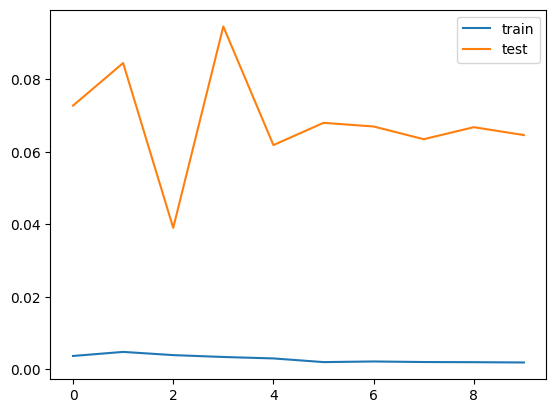

In [9]:
# fit model
history = model.fit(x_training, y_training, epochs=10, batch_size=72, validation_data=(x_validation, y_validation), verbose=1, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# demonstrate prediction
# Nemoj zaboraviti da jedan row je jedan step, a kolona je jedan feature
x_input = x_testing[0]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)
print(y_validation[0])

[[0.5975436  0.611223   0.60246193 0.6098603  0.6025836 ]]
[0.77800046 0.7523072  0.70678445 0.65627923 0.65020185]


In [ ]:
########################################################################################
#Config window, so set all your configurations here


# Function to run ADF test on each column
def adf_test_on_dataframe(dataframe):
    adf_results = {}
    for column in tqdm(dataframe.columns):
        result = adfuller(dataframe[column])
        adf_results[column] = {
            'Test Statistic': result[0],
            'p-value': result[1],
            'Num Lags': result[2],
            'Num Observations used': result[3],
            'Critical Values': result[4],
        }
        
    return adf_results

adf_test1 = adf_test_on_dataframe(dataset)

changed_columns = []
for column in tqdm(dataset.columns):
    if adf_test1[column]['p-value'] > 0.05:
        changed_columns.append(column)
        dataset[column] = dataset[column].diff().fillna(0)

adf_test2 = adf_test_on_dataframe(dataset)



# for column in tqdm(dataset.columns):
#          dataset[column] = dataset[column].pct_change()

# dataset = dataset.dropna()

# if dataset.isna().any().any():
#     print("DataFrame contains NaN values.")
# else:
#     print("DataFrame does not contain NaN values.")

# pd.set_option('display.max_rows', None)

# nan_counts = dataset.isna().sum()
# print("\nNumber of NaN values in each column:")
# print(nan_counts)

# # Total number of NaN values in the DataFrame
# total_nan_count = dataset.isna().sum().sum()
# print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

# # Running the ADF test on each column of the DataFrame
# before,after,new_dataset = adf_test_on_dataframe(dataset)

In [ ]:
changed_columns = []
for column in tqdm(dataset.columns):
    if adf_test2[column]['p-value'] > 0.05:
        changed_columns.append(column)
        dataset[column] = dataset[column].diff().fillna(0)

adf_test3 = adf_test_on_dataframe(dataset)




In [ ]:
# Example of how to print the results
for column, adf_test1 in tqdm(results.items()):
    print(f"Column: {column}")
    for key, value in adf_test1.items():
        print(f"{key}: {value}")
    
    for key, value in adf_test2.items():
        print(f"{key}: {value}")
    # print()
    # for key, value in adf_test3.items():
    #     print(f"{key}: {value}")
    print()  # For better readability
    

In [ ]:
 changed_columns = []
    for column in tqdm(dataframe.columns):
         dataframe[column] = dataframe[column].pct_change()
        # if adf_before[column]['p-value'] > 0.05:
        #     changed_columns.append(column)
        #     dataframe[column] = dataframe[column].diff().fillna(0)

    dataframe = dataframe.fillna(0)
   


adf_after = {}
for column in tqdm(new_dataset.columns):
        result = adfuller(new_dataset[column])
        adf_after[column] = {
            'Test Statistic': result[0],
            'p-value': result[1],
            'Num Lags': result[2],
            'Num Observations used': result[3],
            'Critical Values': result[4],
        }


# Example of how to print the results
for column, adf_after in tqdm(results.items()):
    print(f"Column: {column}")
    for key, value in adf_result.items():
        print(f"{key}: {value}")
    print()  # For better readability
    

In [ ]:



def differentiate_column(column):
    return column.diff().fillna(0)  # Using .diff() for differencing and filling NaNs with 0

print('Differentiating')
for column in tqdm(dataset.columns):
    dataset[column] = differentiate_column(dataset[column])






# If you want to print the ADF test results for each column
print("\nADF Test Results:")
for column, p_value in adf_results.items():
    print(f"{column}: {p_value}")



adf_results = {}  # Initialize an empty dictionary to store ADF test results


def adf_test_values(column):
    result_before_diff = adfuller(column)
    
    # Check if differencing is necessary
    if result_before_diff[1] > 0.05:
        column_diff = column.diff().fillna(0)
        result_after_diff = adfuller(column_diff)
        return {
            'before_diff': result_before_diff[1],
            'after_diff': result_after_diff[1],
        }
    else:
        # If already stationary, no differencing is applied
        return {
            'before_diff': result_before_diff[1],
            'after_diff': None,
        }

adf_results = {}  # Dictionary to store ADF test values

# Iterate through columns and store ADF test values
for column in tqdm(dataset.columns):
    adf_results[column] = adf_test_values(dataset[column])

print(adf_results)


# Now, adf_results contains ADF test values and differentiated columns only if necessary




In [ ]:
# Ovo je basic plotting
# Automatically determine the number of columns
num_columns = dataset.shape[1]  # This gets the number of columns in the DataFrame

pyplot.figure(figsize=(10, num_columns*2))  # Adjust the figure size as needed

# Plot each column
for i in range(num_columns):
    pyplot.subplot(num_columns, 1, i+1)  # Subplots are indexed from 1
    pyplot.plot(scaled[:, i])
    pyplot.title(dataset.columns[i], y=0.5, loc='right')

pyplot.tight_layout()  # Optional: Improves the layout
pyplot.show()

In [ ]:
#My model code



# Model Code 1
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

# Model Code 2
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
# Nemoj zaboraviti da jedan row je jedan step, a kolona je jedan feature
x_input = array([[70, 75], 
                 [80, 85], 
                 [90, 95],
                 [100, 105],
                 [105, 110],])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)